<a href="https://colab.research.google.com/github/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3_pruning_structured_llama3.2-1b_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1>Large Language Models Projects</a></h1>
    <h3>Apply and Implement Strategies for Large Language Models</h3>
    <h2>Pruning Llama 3.2.</h2>
    <h3>Example of approach to width pruning a Llama Model.</h3>
</div>

by [Pere Martra](https://www.linkedin.com/in/pere-martra/)

_______
Contributions:
- [Mariusz Kurman](https://www.linkedin.com/in/mariuszkurman/). Improved the `compute_neuron_pair_importance` function, adding the absolute min value to the equation to evaluate the neurons.
_______
Models: meta-llama/Llama-3.2-1B

Colab Environment: GPU T4.

Keys:
* Pruning
* Structured pruning


Related article: [How to Prune LLaMA 3.2 and Similar Large Language Models](ttps://medium.com/towards-data-science/how-to-prune-llama-3-2-and-similar-large-language-models-cf18e9a2afb6.)
_______

<table style="border: none; background: none;">
  <tr style="border: none;">
    <td style="border: none; vertical-align: middle; width: 120px;">
      <a href="https://hubs.la/Q040tvsK0">
        <img src="https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/Images/cover.png" width="110" style="border-radius: 4px;">
      </a>
    </td>
    <td style="border: none; vertical-align: middle;">
      <h2 style="margin: 0;">The Evolution of LLM Pruning</h2>
      <p style="margin: 5px 0;">Want to know more? check <strong>"Rearchitecting LLMs"</strong> (Manning Publications).</p>
      <p>
        <a href="https://hubs.la/Q040tvsK0"><strong>Check the MEAP</strong></a>
      </p>
    </td>
  </tr>
</table>
______

# Introduction
This notebook cotinues the work done at: [6_2_pruning_structured_llama3.2-1b_KO.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb) where an incorrect pruning was applied to a Llama3.2 model.

The pruning process was based on selecting neurons from the model's MLP layers that have the least importance using the L1 norm, assuming these contributed the least to the model's output.

However, by ignoring the model's structure, some problems arose, which are addressed in this notebook, by taking the actions:

* Consider the GLU (Gated Linear Unit) structure of the MLP layers.
* Use a neuron selection method that is compatible with the GLU structure.

In this notebook, we focus on explaining the modifications made to the pruning process that have successfully allowed us to create a smaller model while retaining almost all the functionalities of the base model.


#Install libraries & Configure variables.

In [ ]:
!pip install -q transformers
!pip install -q torch
!pip install -q datasets
!pip install -q sentencepiece  # Required for LLaMA tokenizer

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch import nn
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#Download model and explore structure

In [ ]:
model_name = 'meta-llama/Llama-3.2-1B'
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
#tokenizer.pad_token = tokenizer.eos_token  # Set pad token

In [ ]:
def get_output(prompt, model=model, tokenizer=tokenizer):
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    outputs = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=50,
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id,
        temperature=None,
        top_p=None,
        do_sample=False,          # Disable sampling
        num_beams=5,              # Use beam search
        early_stopping=True,      # Stop when end-of-sequence token is generated
        no_repeat_ngram_size=2    # Prevent repetition of 2-grams
    )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated

## studying the model structure
As demonstrated in the [previous notebook](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb), studying the structure of the model that will undergo pruning is crucial.

In this notebook, we’re going to fine-tune the pruning process for the Llama3.2 model.

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro


An MLP block typically consists of layers that scale the data to larger dimensions and others that return it to its original size.

In the MLP block of the model, we find two projection layers: `gat_proj` and `up_proj`, both scaling from 2048 to 8192. The purpose of having two layers projecting to the same intermediate size might be related to gating mechanisms. A gating mechanism selectively controls information flow in neural networks by using learned weights to "gate" or filter inputs.

However, to truly understand how these layers function, we’d need to refer to the model's documentation or even the source code. But, this structure usually indicates, at least, I haven't encountered a case where it doesn't, that the layers performing the upsizing work in pairs, and they cannot be treated as independent linear layers.

In other words, any operation we apply to one layer must be replicated in the other. Most importantly, when identifying which neurons have more or less importance, we can't evaluate the neurons of a single layer in isolation; we need to treat them as pairs.



In [ ]:
# Test the original model
prompt = "Paris is the capital of"
generated = get_output(prompt)
print(f"Generated text: {generated}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generated text: Paris is the capital of France and one of the most visited cities in the world. It is a city of art, culture, fashion, and gastronomy. The city has a rich history and is home to many famous landmarks, including the E


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [ ]:
original_param_count = count_parameters(model)
print(f"Original model parameters: {original_param_count}")

Original model parameters: 1235814400


#Pruning the Model.
##Support pruning functions.
###Compute neuron importance functions.

Here are three functions I used to calculate neuron importance, allowing us to decide which ones to eliminate.

All three functions take into account that the layers should be treated as pairs, considering both layers to calculate neuron importance.

The results obtained with each function have been quite different:

* **Product of Norms**: Paris is the capital of of of of the of the the the the to to to from to from from from to to from to
France France France France France France France France France France France
France France France France France

* **Variance of weights**: Paris is the capital of the French Republic. It is also a...
Paris is the capital of the French Republic. It is also a
Germany is the German Republic. It is also a
of the Austrian Republic. It is also a

* **Maximum absolute weight**: Paris is the capital of France. It is also one of the most beautiful cities in the world. There is so much to see and do in Paris that it is impossible to cover it all in one day. However, there are a few things you should not miss while you

* **Base model**: Paris is the capital of France and one of the most visited cities in the world. It is a city with a rich history and culture, as well as a vibrant and diverse population. Paris is home to many famous landmarks, including the Eiff

It seems clear that the **Absolute Maximum** calculation has worked the best. I'd say the other methods for selecting neurons to remove have severely degraded the model, or at least eliminated a significant portion of the base model's capabilities.

*I’m leaving the others in the notebook purely as an exercise.*

The **Maximum Absolute Weight** method works better because it directly identifies the most influential neurons based on the magnitude of their connections. These neurons are likely responsible for key decisions, making the model more accurate after pruning. The Variance of Weights method, while useful in some contexts, can retain neurons that may not contribute significantly to the task, leading to less coherent model outputs.

However, we shouldn’t fall into the trap of assuming that this neuron selection method will work best across all model structures. It works well with Llama models, and this may be due to several factors:

* The relatively large projection from 2048 to 8192.
* The use of a GLU structure.
* The type of activation function used.

So, if we use a model from another family, like Gemma or Mistral, the neuron selection method might need to be entirely different.



In [ ]:
#****DISCARTED****
#Product of Norms:
#Since the GLU multiplies the outputs of gate_proj and up_proj,
#we can compute the product of their weight norms to better represent the
#importance of the neuron pair
def compute_neuron_pair_importance(gate_weight, up_weight):

    gate_norms = torch.norm(gate_weight, p=1, dim=1)
    up_norms = torch.norm(up_weight, p=1, dim=1)
    importance_scores = gate_norms * up_norms
    return importance_scores
#sample response: Paris is the capital of of of of the of the the the the to to to from to from from from to to from to
#France France France France France France France France France France France
#France France France France France
#All All
#All

In [ ]:
#****DISCARTED****
#Variance of Weights
#Neurons with higher weight variance may contribute more to the model's output.
def compute_neuron_pair_importance(gate_weight, up_weight):
    gate_variance = torch.var(gate_weight, dim=1)
    up_variance = torch.var(up_weight, dim=1)
    importance_scores = gate_variance + up_variance
    return importance_scores
#sample response: Paris is the capital of the French Republic. It is also a...
#Paris is the capital of the French Republic. It is also a
#Germany is the German Republic. It is also a
#of the Austrian Republic. It is also a

In [ ]:
#****SELECTED****
#Maximum Absolute Weight:
#The maximum absolute weight in a neuron might indicate its significance.

def compute_neuron_pair_importance(gate_weight, up_weight):
  """
  compute neuron pair importance scores (Maximum Absolute Weight)

  Args:
  - gate_weight: Weight matrix from the gate_proj layer.
  - up_weight: Weight matrix from the up_weight layer.

  Returns:
  - importance_scores: Importance scores for each neuron pair.
  """

  gate_max_abs = torch.max(gate_weight, dim=1).values + torch.abs(torch.min(gate_weight, dim=1).values)
  up_max_abs = torch.max(up_weight, dim=1).values + torch.abs(torch.min(up_weight, dim=1).values)
  importance_scores = gate_max_abs + up_max_abs
  return importance_scores

#response: Paris is the capital of France. It is also one of the most beautiful cities in the world. There is so much to see and do in Paris that it is impossible to cover it all in one day. However, there are a few things you should not miss while you


In [ ]:
#Prunes a specific percentatge of neurons from the MLP (feed forward layers).
def prune_neuron_pairs(mlp, prune_percent):
    """
    Reduces the dimensions of the **gate_proj**,**up_proj**, **down_proj**
    layers removing the least important neurons.

    Args:
    - mlp: Layers to prune.
    - prune_percent: Percentage of neurons to prune.

    Returns:
    - new_gate_proj, new_up_proj, new_down_proj:  New pruned layers.
    - k: New intermediate size.

    """
    # Extract the weights from the MLP layers
    #  these weights are used to calculate each neuron's
    #  importance score in the next step.
    gate_weight = mlp.gate_proj.weight.data.float()
    up_weight = mlp.up_proj.weight.data.float()

    #Compute importance stores. Neurons with higher importance scores
    # are considered more important and less likely to be pruned.
    importance_scores = compute_neuron_pair_importance(gate_weight, up_weight)

    #Store the original number of neurons in the intermediate layer.
    original_intermediate_size = gate_weight.size(0)
    #Computes the number of neurons to prune.
    num_neuron_pairs_to_prune = min(int(prune_percent * original_intermediate_size), original_intermediate_size - 1)
    #Calculate the number of neurons to keep. The new intermediate size.
    k = original_intermediate_size - num_neuron_pairs_to_prune

    #Just check that there is no big error calculating k. We can't prune all the neurons.
    if k <= 0:
        raise ValueError(f"Invalid number of neuron pairs to keep: {k}. Adjust the prune_percent.")

    #Select the neuros to keep, by obtaining the indices to keep.
    _, indices_to_keep = torch.topk(importance_scores, k, largest=True, sorted=True)
    indices_to_keep = indices_to_keep.sort().values

    #create the new layers
    new_gate_proj = nn.Linear(mlp.gate_proj.in_features, k, bias=False).to(device)
    new_up_proj = nn.Linear(mlp.up_proj.in_features, k, bias=False).to(device)
    new_down_proj = nn.Linear(k, mlp.down_proj.out_features, bias=False).to(device)

    #copy weights to the new layers.
    new_gate_proj.weight.data = mlp.gate_proj.weight.data[indices_to_keep, :]
    new_up_proj.weight.data = mlp.up_proj.weight.data[indices_to_keep, :]
    new_down_proj.weight.data = mlp.down_proj.weight.data[:, indices_to_keep]

    #return new layers and intermediate size.
    return new_gate_proj, new_up_proj, new_down_proj, k


# Prune Loop
The update_model function iterates through the blocks within the model's Transformer structure. This structure consists of multiple `LlamaDecoderLayer` blocks, and each of these blocks contains a pair of `LlamaSdpaAttention` and `LlamaMLP` components. The latter contains the MLP layers that will be the target of the pruning process.
```
(layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
  )    
```
The layers that will undergo the removal of neurons identified as less useful are:
```
(gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
(up_proj): Linear(in_features=2048, out_features=8192, bias=False)
(down_proj): Linear(in_features=8192, out_features=2048, bias=False)
```
The neurons are removed in the `prune_neurons` function based on the values returned by `compute_neuron_pair_importance`.

In [ ]:
#Iterates throught the model layers and applies pruning.
def update_model(model, prune_percent):
    """
    It modifies each mlp layer present in model, to retain only the most
    important neurons. Creating new smaller versions of each layer pruned.

    Args:
    - model: Model to prune.
    - prune_percent: Percentage of neurons to prune.

    Returns:
    - model: New pruned model.
    """
    new_intermediate_size = None

    #loop for each model layer.
    for idx, layer in enumerate(model.model.layers):
        #Since each layer is a LlamaDecoderLayer it contains multiple components
        # Attention, MLP and Layer norms. We're targetting MLP component
        # by accesing layer.mlp.
        mlp = layer.mlp

        #Call the prune_neiron_pairs with the layers and receiving the pruned.
        new_gate_proj, new_up_proj, new_down_proj, new_size = prune_neuron_pairs(mlp, prune_percent)

        #Replace the Origiginal Layers with Pruned Layers.
        mlp.gate_proj = new_gate_proj
        mlp.up_proj = new_up_proj
        mlp.down_proj = new_down_proj

        #new_intermediate_size only needs to be set once
        if new_intermediate_size is None:
            new_intermediate_size = new_size

    #Update the model config file.
    model.config.intermediate_size = new_intermediate_size

    return model


## Obtain & test the pruned model.

In [ ]:
prune_percent = 0.2  # Prune 20% of neurons
model = update_model(model, prune_percent)

In [ ]:
# Recalculate the number of parameters
pruned_param_count = count_parameters(model)
reduction_in_params = original_param_count - pruned_param_count
percentage_savings = (reduction_in_params / original_param_count) * 100

print(f"Pruned model parameters: {pruned_param_count}")
print(f"Reduction in parameters: {reduction_in_params}")
print(f"Percentage of weight savings: {percentage_savings:.2f}%")


Pruned model parameters: 1074792448
Reduction in parameters: 161021952
Percentage of weight savings: 13.03%


In [ ]:
# Test the pruned model
generated = get_output(prompt, model, tokenizer)
print(f"Generated text after pruning: {generated}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generated text after pruning: Paris is the capital of France. It is also one of the most beautiful cities in the world. There is so much to see and do in Paris that it is impossible to cover it all in one day. However, there are some things you


The result is slightly different from what the original model produced, but it’s still a fairly accurate response.

In contrast to the model created in notebook: [6_2_pruning_structured_llama3.2-1b_KO.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb) where the pruned Llama model lost almost all its utility, the model in this notebook retains a good portion of its knowledge.

Looking at the model’s new structure, we can see that the `gate_proj` and `up_proj` layers have had their `out_features` reduced to 6554 from 8192. Consequently, the `down_proj` layer has its `in_features` adjusted to match the new size.

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=6554, bias=False)
          (up_proj): Linear(in_features=2048, out_features=6554, bias=False)
          (down_proj): Linear(in_features=6554, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro

#Upload the model to HuggingFace.

In [ ]:
new_model_name = 'pruned20-llama-1b-st'
output_dir = './'+new_model_name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Pruned model saved to {output_dir}")

Pruned model saved to ./pruned20-llama-1b-st


In [ ]:
# Push the model to your Hugging Face repository

model.push_to_hub(new_model_name, private=True)

In [ ]:
tokenizer.push_to_hub(new_model_name)

#Evaluating models

In this section, we'll take a look at some standard evaluations in the world of Large Language Models using the lm-evaluation library from EleutherAI.

Specifically, we'll use LAMBADA and BoolQ. Since the pruning performed could be considered structural—that is, it affects the model's overall structure without a specific target—I’ve chosen two rather different evaluation tasks.

I want to remind you that the goal of this notebook is to demonstrate the pruning process, so I won’t be doing a comprehensive study of how it impacts performance; that will be saved for a future article. Additionally, these models are designed to be fine-tuned before being used.

However, I believe that seeing how pruning impacts model performance can help illustrate the pruning process itself.

In [ ]:
!pip install -q lm-eval
from lm_eval import evaluator, tasks, models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 140.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
def evaluate_hf_model(model_name, tasks=['arc_easy'], num_fewshot=0):
    """
    It calls the evaluator to evaluate a model available on Hugging Face.

    Args:
    - model_name: The model name in hugging Face.
    - tasks: Tasks to evaluate.
    - num_fewshot: Number of examples of few-shot learning

    Returns:
    - metrics.
    """
    model_args = f"pretrained={model_name},device=cuda"
    tasks = tasks

    results = evaluator.simple_evaluate(
      model="hf",
      model_args=model_args,
      tasks=tasks,
      num_fewshot=0,  # Number of few-shot smaples.
      limit=None,  # Use all the samples in the Evaluate Dataset.
      bootstrap_iters=10
    )

    metrics = results.get('results', {})
    return metrics

In [ ]:
# Select tasks to evaluate.
tasks = ['lambada', 'boolq']

In [ ]:
metrics_base = evaluate_hf_model("meta-llama/Llama-3.2-1B", tasks=tasks)

In [ ]:
metrics_base

{'boolq': {'alias': 'boolq',
  'acc,none': 0.6342507645259939,
  'acc_stderr,none': 0.008423930068850893},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 5.750747714233767,
  'perplexity_stderr,none': 0.19322502196591998,
  'acc,none': 0.6192509217931302,
  'acc_stderr,none': 0.006764953783983667},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 8.674909863138824,
  'perplexity_stderr,none': 0.38121670005633623,
  'acc,none': 0.5342518921016883,
  'acc_stderr,none': 0.006949613576317933}}

In [ ]:
metrics_pruned = evaluate_hf_model("oopere/pruned40-llama-1b", tasks=tasks)

In [ ]:
metrics_pruned

{'boolq': {'alias': 'boolq',
  'acc,none': 0.6220183486238532,
  'acc_stderr,none': 0.008480656964585113},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 90.37589664306546,
  'perplexity_stderr,none': 5.033864064766977,
  'acc,none': 0.29342130797593635,
  'acc_stderr,none': 0.00634363469055969},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 171.43494507234763,
  'perplexity_stderr,none': 8.212744131805762,
  'acc,none': 0.24121870754900057,
  'acc_stderr,none': 0.0059604064139166454}}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(metrics_base, metrics_pruned):

    tasks_to_plot = ['boolq', 'lambada_openai', 'lambada_standard']
    display_labels = ['BoolQ', 'Lambada OpenAI', 'Lambada Standard']

    try:
        base_scores = [metrics_base[task]['acc,none'] for task in tasks_to_plot]
        pruned_scores = [metrics_pruned[task]['acc,none'] for task in tasks_to_plot]
    except KeyError as e:
        return

    n_groups = len(tasks_to_plot)
    index = np.arange(n_groups)
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    color_base = '#3366CC'
    color_pruned = '#DC3912'

    ax.bar(index - bar_width / 2,
           base_scores,
           bar_width,
           label='Base Model',
           color=color_base)

    ax.bar(index + bar_width / 2,
           pruned_scores,
           bar_width,
           label='Pruned Model',
           color=color_pruned)

    ax.set_ylim([0, 0.9])
    ax.set_yticks(np.arange(0, 0.9, 0.2))
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(display_labels)

    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
    ax.set_axisbelow(True)

    ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

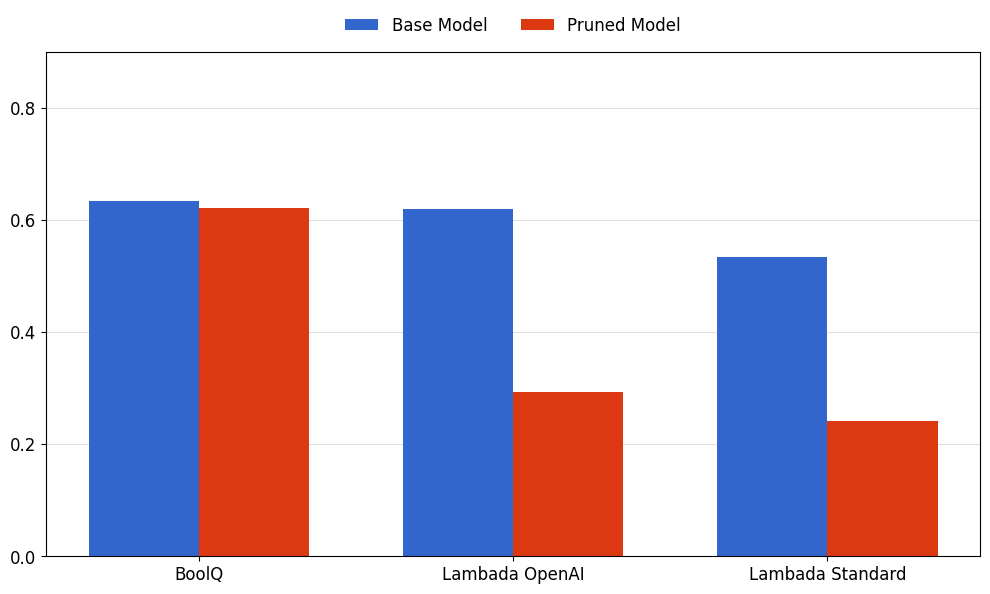

In [ ]:
plot_model_comparison(metrics_base, metrics_pruned)

As we can see, the effect of pruning has been somewhat asymmetrical. The tasks evaluated by the BoolQ test haven’t experienced significant degradation—only about a 2% drop for a model that lost 35% of its weight.

In contrast, the impact on the Lambada test has been remarkable, with a drop in accuracy of over 50%.

This indicates that the model retains much of its comprehension ability but struggles with tests requiring more open-ended generation.

BoolQ simply presents the model with a text and a question to be answered with Yes/No. It’s a test focused on measuring the model’s ability to understand relationships within the input text.

Lambada, on the other hand, asks the model to guess the last word of a paragraph, a complex task where the final word tests the model’s capability in complex language modeling.

These results are consistent with the functionality of the MLP layers that were pruned.


#Conclusion.
This time, we successfully pruned the Llama model correctly. This same procedure could be applied to any model that shares this structure, regardless of its size.

We’ve managed to reduce the model’s size while, at least initially, preserving much of its functionality, depending on the % pruned and the task demanded to the model.

It’s important to remember that a pruned model doesn’t typically have direct application on its own; rather, it often serves as the foundation for a new model obtained through further training.

## Future Work.
The first three notebooks of the course have focused on a type of structured pruning that removes neurons deemed less important.

We should explore other forms of structured pruning, such as removing entire layers, as well as different ways to determine which elements are pruned from the model. One such method is Activation-Based Pruning, where neuron activations are evaluated using a specific dataset, and those with low activation are removed.


##Authors Note.
In addition to creating content like this notebook and offering it under the MIT license, I have also contributed to repositories such as those of Hugging Face and Google Gemini.

I am especially proud of my book: <a href="https://hubs.la/Q040tvsK0"><b>Rearchitecting LLMs - Structural techniques for efficient models</b></a> (Manning Publications).

You can find it at Manning.

If you take a look and end up purchasing it, keep in mind that you can reach out with any questions via the Discussions section of this same repository or on any of my social media channels. I’ll do my best to respond as quickly as possible.